채점 기준: Log Loss


In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm, skew # 수치해석 기능(확률분포) 제공
from collections import Counter
from sklearn.model_selection import train_test_split

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/천체 유형 분류/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/천체 유형 분류/test.csv')

train_id = train['id']
test_id = test['id']

# 필요없는 Id 컬럼, Drop하자.
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

# 'Id'를 제거한 DataFrame의 Shape 확인
print("The train data size after dropping ID feature is : {} ".format(train.shape))
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size after dropping ID feature is : (199991, 22) 
The test data size after dropping Id feature is : (10009, 21) 


In [194]:
train.head()

,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
0,QSO,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340
1,QSO,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314
2,QSO,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928
3,QSO,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855
4,STAR_RED_DWARF,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,19.861718,18.810375,25.859229,22.426929,21.673551,19.610012,18.376141,24.877052,23.147993,21.475342,19.487330,18.375655


In [195]:
train.describe()

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,360.830152,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,225.305890,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,1.000000,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,174.000000,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,349.000000,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,526.000000,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1000.000000,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


'psfMag_u'빼고는 대부분 scale이 비슷하게 형성되어 있는 것 같음.

In [196]:
# NA 값 확인 : 없음
train.isnull().sum()

type          0
fiberID       0
psfMag_u      0
psfMag_g      0
psfMag_r      0
psfMag_i      0
psfMag_z      0
fiberMag_u    0
fiberMag_g    0
fiberMag_r    0
fiberMag_i    0
fiberMag_z    0
petroMag_u    0
petroMag_g    0
petroMag_r    0
petroMag_i    0
petroMag_z    0
modelMag_u    0
modelMag_g    0
modelMag_r    0
modelMag_i    0
modelMag_z    0
dtype: int64

In [197]:
train['type'].value_counts()

QSO                    49680
GALAXY                 37347
SERENDIPITY_BLUE       21760
SPECTROPHOTO_STD       14630
REDDEN_STD             14618
STAR_RED_DWARF         13750
STAR_BHB               13500
SERENDIPITY_FIRST       7132
ROSAT_D                 6580
STAR_CATY_VAR           6506
SERENDIPITY_DISTANT     4654
STAR_CARBON             3257
SERENDIPITY_RED         2562
STAR_WHITE_DWARF        2160
STAR_SUB_DWARF          1154
STAR_BROWN_DWARF         500
SKY                      127
SERENDIPITY_MANUAL        61
STAR_PN                   13
Name: type, dtype: int64

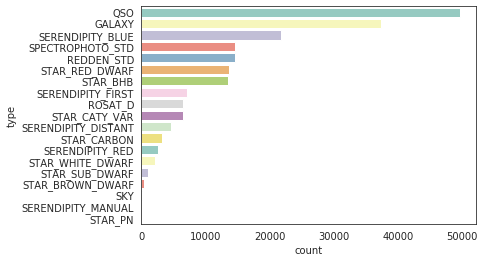

In [198]:
sns.set_style('white')
sns.countplot(y=train['type'],
              order = train['type'].value_counts().index,
              palette="Set3")
# plt.xticks(rotation='90')
plt.show()

데이터셋은 상당히 Unbalanced 함.

# EDA

## Categorical Data

In [225]:
train.groupby('fiberID')['type'].value_counts()

fiberID  type            
1        GALAXY              61
         SERENDIPITY_BLUE    42
         REDDEN_STD          30
         SPECTROPHOTO_STD    29
         STAR_BHB            27
                             ..
996      QSO                 72
997      QSO                 14
998      QSO                 75
999      QSO                 27
1000     QSO                 67
Name: type, Length: 10346, dtype: int64

## 데이터 결합

train 데이터와 test데이터를 하나의 데이터프레임으로 합치자.
 -  Feature engineering, Pre-processing 할 때 동일하게 작업하기 위해서이다. 

'''
all_data의 크키는 : (210000, 21)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
  '''

In [200]:
ntrain = train.shape[0] # 행 개수 반환
ntest = test.shape[0] # 행 개수 반환
y_train = train['type'].values # array로 type 반환
all_data = pd.concat((train,test)).reset_index(drop=True)
all_data.drop(['type'],axis=1,inplace=True)
print('all_data의 크키는 : {}'.format(all_data.shape))

all_data의 크키는 : (210000, 21)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


## psfMag

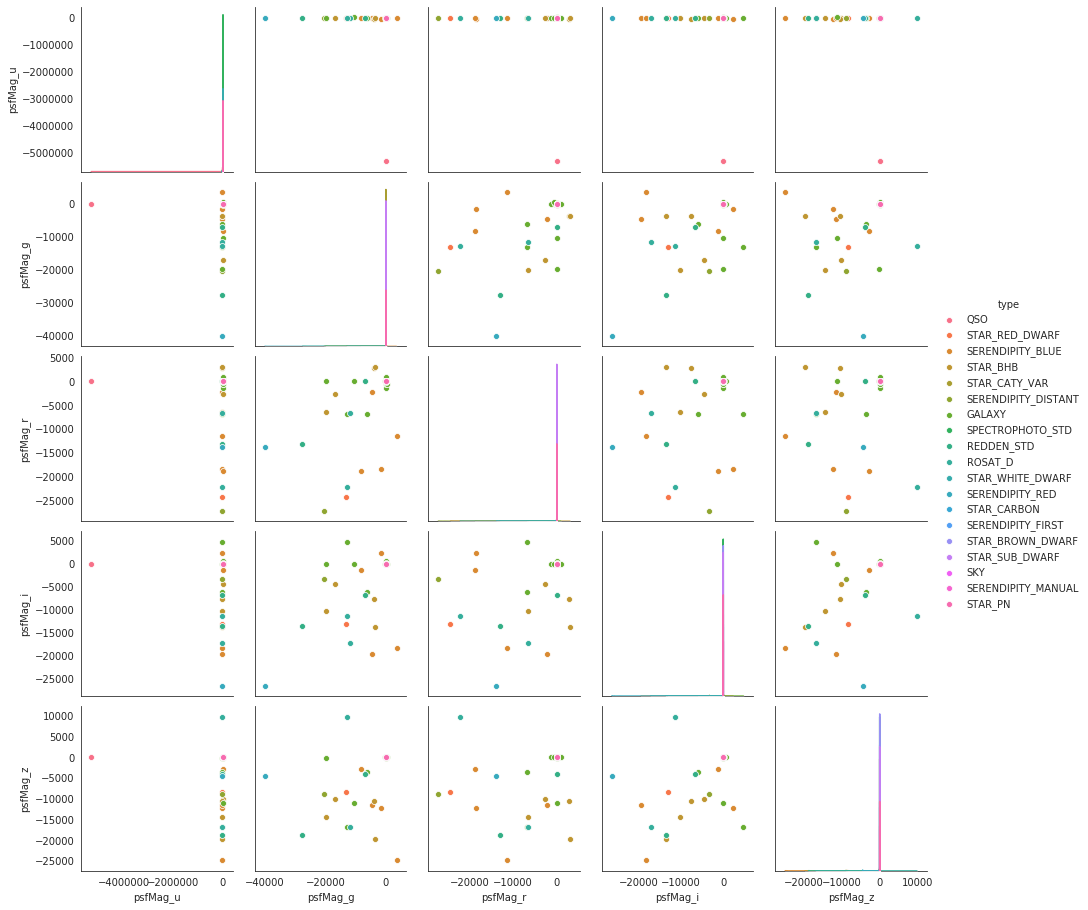

In [201]:
sns.pairplot(train[['psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z','type']],hue='type')

psfMag_u 와 나머지 변수들이 같은 선형성을 띄고 있는 것 같긴함.

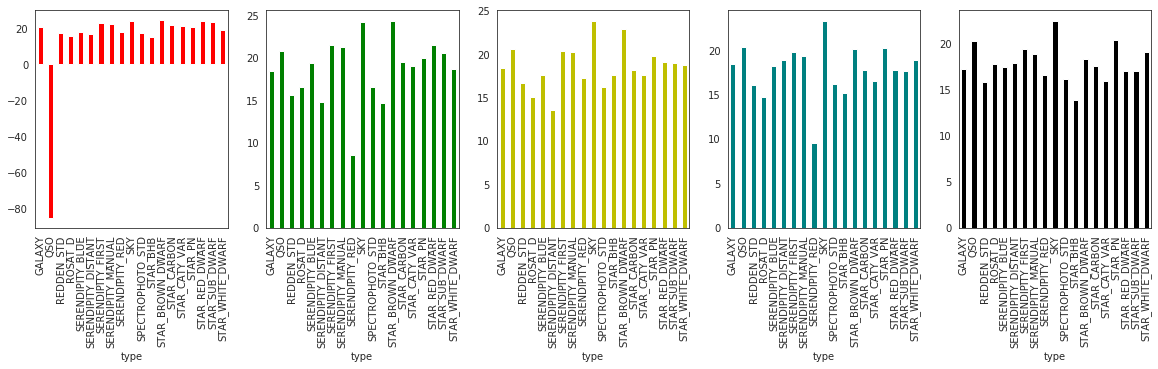

In [202]:
plt.subplot(1,5,1)
train.groupby('type').mean()['psfMag_u'].plot(kind='bar',figsize=(20,4), color='r')
plt.subplot(1,5,2)
train.groupby('type').mean()['psfMag_g'].plot(kind='bar',figsize=(20,4), color='g')
plt.subplot(1,5,3)
train.groupby('type').mean()['psfMag_r'].plot(kind='bar',figsize=(20,4), color='y')
plt.subplot(1,5,4)
train.groupby('type').mean()['psfMag_i'].plot(kind='bar',figsize=(20,4), color='teal')
plt.subplot(1,5,5)
train.groupby('type').mean()['psfMag_z'].plot(kind='bar',figsize=(20,4), color='k')

- 일변량 확인(all_data)

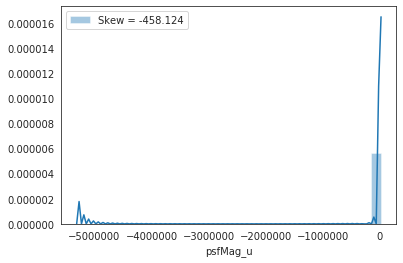

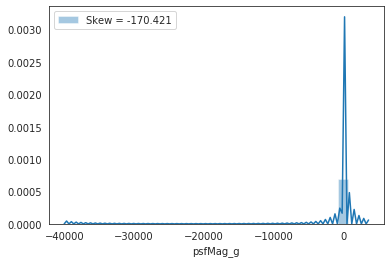

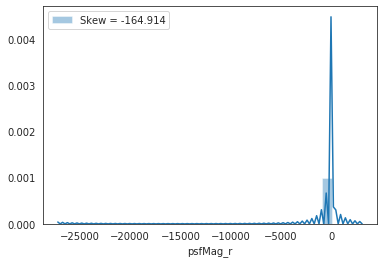

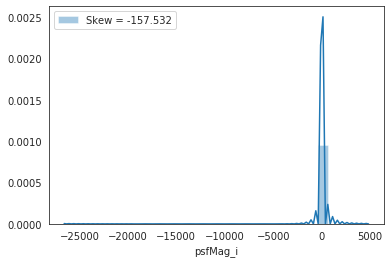

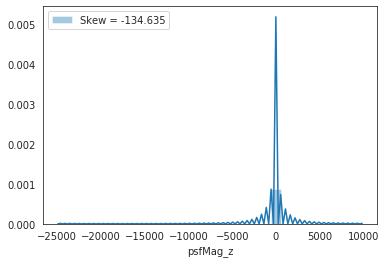

In [203]:
# f, axes = plt.subplots(1,5, figsize=(100, 7), sharex=True)
# for i,feat in enumerate(['psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z']):
#   skew = train[feat].skew()
#   sns.distplot(train[feat],kde = False,label = 'Skew = %.3f' % (skew),bins=30,ax=axes[i,])
#   plt.legend(loc='best')
# plt.show()

for feat in ['psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z']:
    skew = all_data[feat].skew()
    sns.distplot(all_data[feat], kde= True, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

 all_data의 모든 psfMag_feature가 정규분포가 아님. 심지어 이상치도 상당히 많이 있음. 
 - Turkey's method를 통해 아웃라이어를 포함하는 곳을 찾자.

In [204]:
# Detect observations with more than one outlier

def outlier_hunt(train):
    """
    Takes a dataframe train of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in ['psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z']:
        # 1st quartile (25%)
        Q1 = np.percentile(train[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(train[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = train[(train[col] < Q1 - outlier_step) | (train[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(all_data[['psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z']]))))   

The dataset contains 149 observations with more than 2 outliers


다수의 이상치를 가지고 있는 149개의 관측치가 존재함. 다음 단계에서 없애보자.

Boxplot

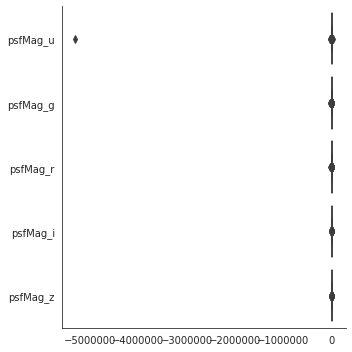

In [205]:
sns.catplot(data=all_data[['psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z']],orient="h",kind="box")

### Data(psfMag) transformation
- It should be emphasized that all transformations should only be done on the training set to avoid data snooping. Otherwise the test error estimation will be biased.

In [0]:
numeric_feats = all_data.dtypes[['psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z']].index
print(skew(all_data[numeric_feats]))

# 숫자형 변수중에 치우침을 확인해 보자.
skewed_feats = all_data[numeric_feats].apply(
    lambda x: 
    skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

In [0]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
  #all_data[feat] += 1
  all_data[feat] = boxcox1p(all_data[feat],lam)

#all_data[skewed_features] = np.log1p(all_data[skewed_features])

In [0]:
all_data[['psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z']].describe()

In [0]:
numeric_feats = all_data.dtypes[['psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z']].index
#print(skew(all_data[numeric_feats]))

# 숫자형 변수중에 치우침을 확인해 보자.
skewed_feats = all_data[numeric_feats].apply(
    lambda x: 
    skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

완벽하게 줄어들진 않았지만 Skew정도가 상당히 줄어들긴 함.

### Feature(psfMag) Engineering

In [0]:
train['psfMag_u*g'] = train['psfMag_u'] *train['psfMag_g']
train['psfMag_u*r'] = train['psfMag_u'] *train['psfMag_r']
train['psfMag_u*i'] = train['psfMag_u'] *train['psfMag_i']
train['psfMag_u*z'] = train['psfMag_u'] *train['psfMag_z']

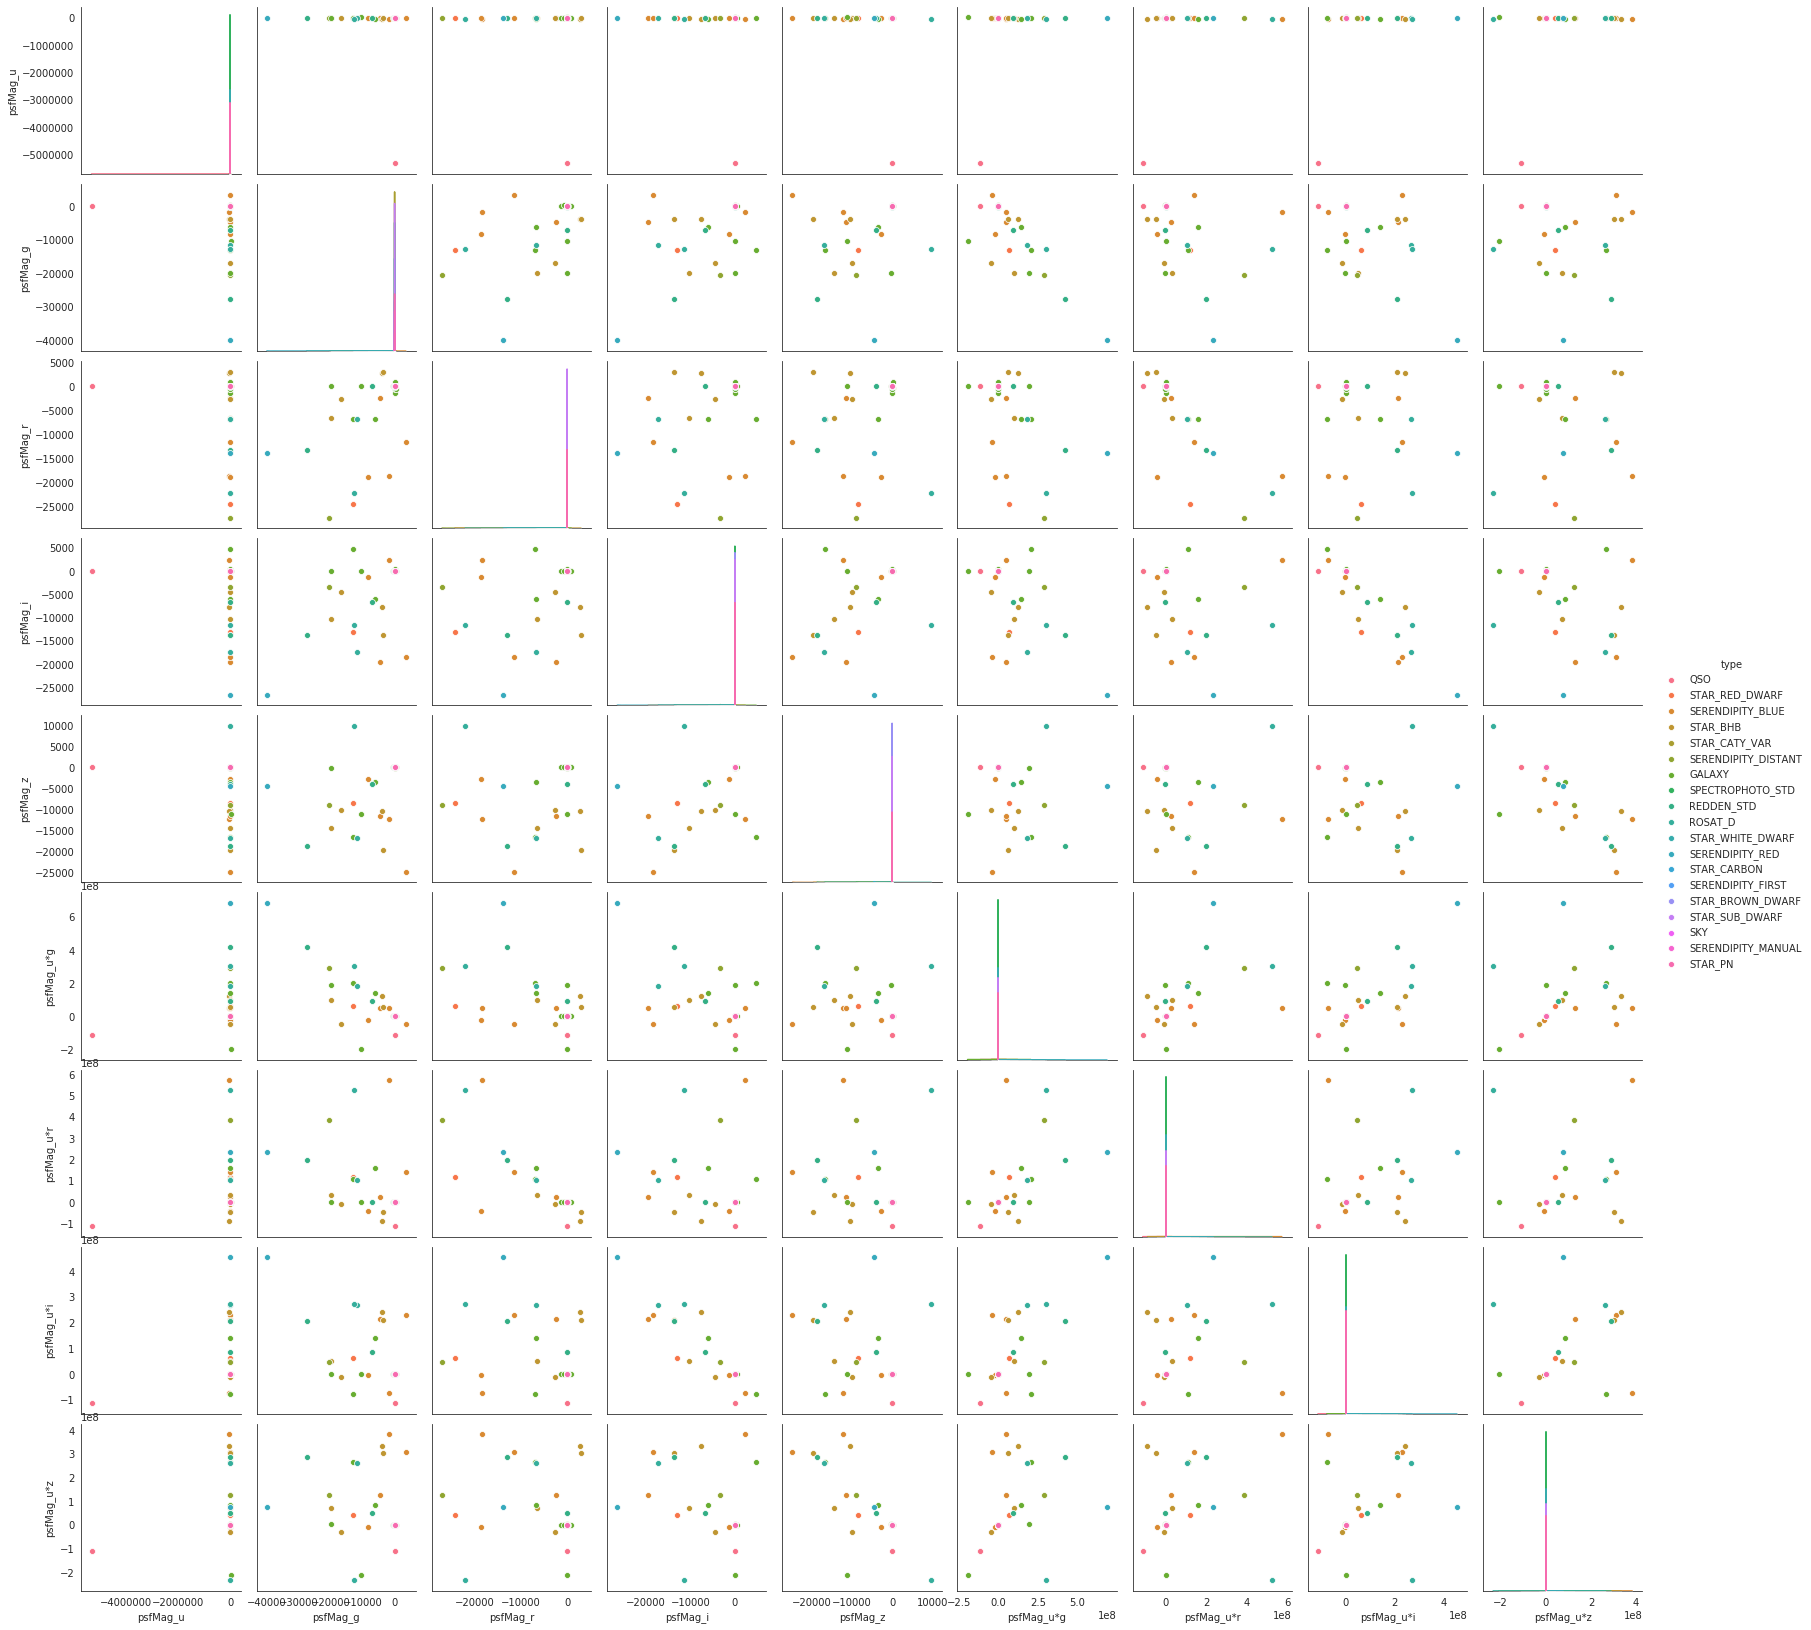

In [229]:
sns.pairplot(train[['psfMag_u','psfMag_g','psfMag_r','psfMag_i','psfMag_z',
                    'psfMag_u*g','psfMag_u*r','psfMag_u*i','psfMag_u*z','type']],hue='type')

In [0]:
# 똑같이 test에도 적용

test['psfMag_u*g'] = test['psfMag_u'] *test['psfMag_g']
test['psfMag_u*r'] = test['psfMag_u'] *test['psfMag_r']
test['psfMag_u*i'] = test['psfMag_u'] *test['psfMag_i']
test['psfMag_u*z'] = test['psfMag_u'] *test['psfMag_z']

In [0]:
train.to_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/천체 유형 분류/train_psfMag.csv')
test.to_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/천체 유형 분류/test_psfMag.csv')